In [1]:
%pip install langchain_core langgraph python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pydantic import BaseModel, Field
from langchain_core.tools import BaseTool
from typing import Optional, Type, Dict, List, Any, Tuple
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from typing import TypedDict, Annotated, Sequence
from langgraph.graph.message import add_messages
from IPython.display import display, Image


import json
import re
from collections import defaultdict

## **Initialize Pydantic Tools and Input**

In [3]:
# Input model for the agent
class AgentInput(BaseModel):
    """Input model for the agent"""
    input_text: str

class RegexExtractionTool(BaseTool):
    """Tool for extracting unit readings using regex"""
    name: str = "regex_extraction"
    description: str = "Extract unit readings from natural language text using regex pattern"
    pattern: str = r'(?:Unit\s+)?(\d+[A-Z])\s+(?:reads|is|reading)\s+(\d+(?:\.\d+)?)\s++(?:cubic\s+meter|m\^3|m3)'

    def _run(self, input_text: str) -> List[Tuple[str, str]]: # Ex. Output = [('Unit 1', '123.45'), ('Unit 2', '67.89')]
        """Extract unit and reading pairs from input text"""
        matches = re.findall(self.pattern, input_text, re.IGNORECASE)
        return matches

    async def _arun(self, input_text: str) -> List[Tuple[str, str]]:
        """Async version of _run"""
        return self._run(input_text)

class ValidationTool(BaseTool):
    """Tool for validating extracted unit readings"""
    name: str = "validation"
    description: str = "Validate extracted unit readings for duplicates and conflicts"

    def _run(self, matches: List[Tuple[str, str]]) -> Dict[str, Any]: # Ex. Output = {'is_valid': True, 'errors': [], 'duplicates_found': False, 'conflicts_found': False, 'conflicts': {}}
        """Validate matches and return validation results"""
        validation_result = {
            "is_valid": True,
            "errors": [],
            "duplicates_found": False,
            "conflicts_found": False,
            "conflicts": {}
        }

        # Check validity of matches
        if not matches:
            validation_result["is_valid"] = False
            validation_result["errors"].append("No unit readings found")
            return validation_result

        # Check for exact duplicates
        seen_units = set()
        for unit, reading in matches:
            if unit in seen_units:
                validation_result["duplicates_found"] = True
                validation_result["errors"].append(f"Duplicate unit found: {unit}")
            seen_units.add(unit)

        # Check for conflicting values
        unit_readings = defaultdict(list)
        for unit, reading in matches:
            unit_readings[unit].append(reading)

        conflicts = {}
        for unit, readings in unit_readings.items():
            unique_readings = list(set(readings))
            if len(unique_readings) > 1:
                conflicts[unit] = unique_readings
                validation_result["conflicts_found"] = True

        if conflicts:
            validation_result["is_valid"] = False
            validation_result["conflicts"] = conflicts
            for unit, values in conflicts.items():
                validation_result["errors"].append(
                    f"Conflicting readings for Unit {unit}: {', '.join(values)} cubic meters"
                )

        return validation_result

    async def _arun(self, matches: List[Tuple[str, str]]) -> Dict[str, Any]:
        """Async version of _run"""
        return self._run(matches)

class RemoveDuplicates(BaseTool):
    """Tool for processing validated data into JSON format"""
    name: str = "remove_duplicates"
    description: str = "Clean unit reading duplicates from input matches"

    def _run(self, matches: List[Tuple[str, str]]) -> List[Dict[str, Any]]:
        """Process matches into structured data format"""
        result = []

        # Remove duplicates while preserving order
        seen_units = set()
        unique_matches = []
        for unit, reading in matches:
            if unit not in seen_units:
                unique_matches.append((unit, reading))
                seen_units.add(unit)
    
        return unique_matches

class CreateJSON(BaseTool):
    """Convert validated matches into JSON file"""

    name: str = "data_processing"
    description: str = "Process validated unit readings into structured JSON format"

    def _run(self, matches: List[Tuple[str, str]]) -> str: 

        result = []

        for unit, reading in matches:
            unit_data = {
                "unit": unit,
                "reading": int(float(reading))
            }
            result.append(unit_data)

        json_output = json.dumps(result, indent=4)

        return result

        

In [4]:
# Custom Reasoner class for unit reading processing
class UnitReadingReasoner:
    def __init__(self, tools: List[BaseTool]):
        self.tools = {tool.name: tool for tool in tools}
        self.processing_steps = [
            "regex_extraction",
            "validation",
            "remove_duplicates",
            "data_processing"
        ]
        # Initialize log for thoughts, actions, and observations
        self.log = []
        self.step = 0

    def log_tao(self, type: str, description: str):
        """Log thought, action, and observation."""
        self.log.append(f"{type}: {description}")
        print(f"{type}: {description}")

    def _think_initial(self, user_input: str) -> str:
            """Initial reasoning about the input."""
            if self._contains_unit_readings(user_input):
                return "I can see unit readings in the input. I need to extract them first."
            else:
                return "I don't see any unit readings in this input. I should inform the user."
    
    def reason(self, user_input: str) -> Tuple[str, List[Dict[str, Any]]]:

        """Main reasoning method that decides processing steps for unit readings."""
        # Check if input contains unit reading patterns
        print(f"{80 * '='}\n ReAct Simulation\n{80 * '='}")
    
        self.log_tao("💭 Thought", "I need to check if there is a viable input") 

        if self._contains_unit_readings(user_input):
            tool_calls = [
                {
                    'tool': 'regex_extraction',
                    'args': {'input_text': user_input},
                    'step': 1
                }
            ]
            self.log_tao("💭 Thought", "I'll process your unit readings step by step.") 
            self.step = 1
            return "I'll process your unit readings step by step.", tool_calls
        else:
            return "I don't detect any unit readings in your input. Please provide text containing unit readings in the format 'Unit 1A reads 123.45 cubic meter'.", []

    def _contains_unit_readings(self, text: str) -> bool:
        """Check if text contains unit reading patterns."""
        # Log the action of checking for inputs
        self.log_tao("🔧 Action", "Checking for inputs using _contains_unit_readings()") 

        keywords = ["cubic meter", "m3", "m^3"]

        if any(keyword in text for keyword in keywords):
            # Log the observation of viable input
            self.log_tao("👁️ Observation", "Viable input found")
            return True
        
        else:
            self.log_tao("👁️ Observation", "No viable input found")
            return False
        
    def execute_tool_call(self, tool_name: str, args: Dict[str, Any]) -> Any:
        """Execute a tool call with given arguments."""
        if tool_name not in self.tools:
            return f"Error: Tool '{tool_name}' not found"

        tool = self.tools[tool_name]
        try:
            # Pass args directly to the tool's _run method
            if hasattr(tool, '_run'):
                self.log_tao("🔧 Action", f"Executing tool '{tool_name}' with args: {args}")
                # if self.step == 4:
                #     self.log_tao("👁️ Observation", "Final JSON is ready to export")
                #     print(f"{80 * '='}\n")
                return tool._run(**args)
            else:
                return f"Error: Tool '{tool_name}' does not have a _run method."
        except Exception as e:
            return f"Error executing {tool_name}: {str(e)}"

    def get_next_step(self, current_step: int, validation_result: Dict[str, Any] = None) -> Optional[Dict[str, Any]]:
        """Determine the next processing step based on current results."""
        if current_step == 1:  # After regex extraction
            self.log_tao("👁️ Observation", "Unit and Water Meter Reading pairs found")
            self.log_tao("💭 Thought", "I'll validate the extracted unit readings")
            self.step = 2

            return {
                'tool': 'validation',
                'args': {'matches': None},  # Will be filled with extraction results
                'step': 2
            }
        elif current_step == 2:  # After validation
            if validation_result and validation_result.get('is_valid', False):
                if validation_result.get('duplicates_found', False):
                    errors = validation_result.get('errors', [])
                    for error in errors:
                        self.log_tao("👁️ Observation", f"Duplicates found, {error}")
                        self.log_tao("💭 Thought", "I'll remove extraction matches duplicates")
                        
                    self.step = 3

                    return {
                    'tool': 'remove_duplicates',
                    'args': {'matches': None},  # Will be filled with extraction results
                    'step': 3
                    }
                
                else:
                    self.log_tao("👁️ Observation", "Validation done, no issues found")
                    self.log_tao("💭 Thought", "I'll process the validated matches into JSON file")
                    self.step = 4
                    
                    return {
                    'tool': 'data_processing',
                    'args': {'matches': None},  # Will be filled with extraction results
                    'step': 4
                    }
                
            else:
                if validation_result.get('conflicts_found', False):
                    conflicts = validation_result.get('conflicts', {})
                    for unit, readings in conflicts.items():
                        self.log_tao("👁️ Observation", f"Conflicting values found, Unit {unit}: {', '.join(readings)}")
            
                print(f"{80 * '='}\n")
                return None  # Stop processing if validation failed
            
        
        else:
            self.log_tao("👁️ Observation", "Final JSON is ready to export")
        
            print(f"{80 * '='}\n")
            return None
    
    def synthesize_results(self, user_input: str, all_results: List[Dict[str, Any]]) -> str:
        """Synthesize all processing results into a coherent response."""
        if not all_results:
            return "No results to process."

        response_parts = []

        # Find results by step
        extraction_result = next((r for r in all_results if r.get('step') == 1), None)
        validation_result = next((r for r in all_results if r.get('step') == 2), None)
        duplicates_result = next((r for r in all_results if r.get('step') == 3), None)
        processing_result = next((r for r in all_results if r.get('step') == 4), None)

        if extraction_result:
            matches = extraction_result.get('output')
            response_parts.append(f"📊 **Extraction Results:**")
            if matches:
                response_parts.append(f"Found {len(matches)} unit readings:")
                for unit, reading in matches:
                    response_parts.append(f"  - Unit {unit}: {reading} cubic meters")
            else:
                response_parts.append("No unit readings found in the input.")

        if validation_result:
            validation_data = validation_result.get('output')
            response_parts.append(f"\n✅ **Validation Results:**")

            if validation_data and validation_data.get('is_valid', False):
                response_parts.append("All unit readings are valid!")
            else:
                response_parts.append("Validation issues found:")
                errors = validation_data.get('errors', []) if validation_data else []
                for error in errors:
                    response_parts.append(f"  ⚠️ {error}")

            if validation_data and validation_data.get('duplicates_found', False):
                response_parts.append("  🔄 Duplicates detected")

            if validation_data and validation_data.get('conflicts_found', False):
                response_parts.append("  ⚡ Conflicts detected:")
                conflicts = validation_data.get('conflicts', {}) if validation_data else {}
                for unit, readings in conflicts.items():
                    response_parts.append(f"    - Unit {unit}: {', '.join(readings)}")

        if duplicates_result:
            unique_matches = duplicates_result.get('output')
            response_parts.append(f"\n🔄 **Duplicates Removed:**")
            if unique_matches:
                response_parts.append(f"Found {len(unique_matches)} unique unit readings:")
                for unit, reading in unique_matches:
                    response_parts.append(f"  - Unit {unit}: {reading} cubic meters")
            else:
                response_parts.append("No unique unit readings found after removing duplicates.")
        

        if processing_result:
            processed_data = processing_result.get('output')
            response_parts.append(f"\n🔧 **Final Processed Data:**")
            if processed_data:
                response_parts.append("```json")
                response_parts.append(json.dumps(processed_data, indent=2))
                response_parts.append("```")

                response_parts.append(f"\n📈 **Summary:**")
                response_parts.append(f"Successfully processed {len(processed_data)} unique unit readings")
            else:
                response_parts.append("No data processed.")


        return "\n".join(response_parts)
    
# Workflow State
class WorkflowState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    current_step: int
    extraction_results: List[Tuple[str, str]]
    validation_results: Dict[str, Any]
    processing_results: List[Dict[str, Any]]
    pending_tool_calls: List[Dict[str, Any]]
    all_results: List[Dict[str, Any]]


## **Initialize LangGraph Workflow**

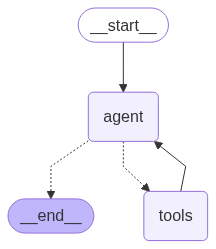

In [5]:
# Initialize tools and reasoner
regex_tool = RegexExtractionTool()
validation_tool = ValidationTool()
duplicates_tool = RemoveDuplicates()
processing_tool = CreateJSON()
tools = [regex_tool, validation_tool, duplicates_tool, processing_tool]

reasoner = UnitReadingReasoner(tools)

# Create the workflow
workflow = StateGraph(WorkflowState)

def agent_node(state: WorkflowState):
    """Main agent node using the UnitReadingReasoner class."""
    messages = state["messages"]
    last_message = messages[-1]

    if isinstance(last_message, HumanMessage):
        # Initial reasoning
        response_text, tool_calls = reasoner.reason(last_message.content)

        if tool_calls:
            # Create AI message indicating tool usage
            ai_message = AIMessage(
                content=response_text,
                additional_kwargs={"tool_calls": tool_calls}
            )
            return {
                "messages": [ai_message],
                "pending_tool_calls": tool_calls,
                "current_step": 1,
                "all_results": []
            }
        else:
            # Direct response without tools
            return {"messages": [AIMessage(content=response_text)]}

    # Handle completion of processing steps
    elif state.get("all_results"):
        # Check if we need to continue processing
        current_step = state.get("current_step", 0)

        if current_step > 0 and current_step < 4:  # Still have steps to process
            # Get the last result to determine next step
            last_result = state["all_results"][-1] if state["all_results"] else None

            if current_step == 1:  # After extraction
                extraction_matches = last_result['output'] if last_result and 'output' in last_result else []
                next_step = reasoner.get_next_step(current_step)
                if next_step:
                    next_step['args']['matches'] = extraction_matches
                    return {
                        "pending_tool_calls": [next_step],
                        "current_step": current_step + 1
                    }

            elif current_step == 2:  # After validation
                # Get the original dictionary output from the validation tool
                validation_result_dict = last_result['output'] if last_result and 'output' in last_result and isinstance(last_result['output'], dict) else {}
                next_step = reasoner.get_next_step(current_step, validation_result_dict)

                if next_step:
                    # Get original extraction results to pass to processing
                    extraction_result = next((r for r in state["all_results"] if r.get('step') == 1), None)
                    extraction_matches = extraction_result['output'] if extraction_result and 'output' in extraction_result else []
                    next_step['args']['matches'] = extraction_matches
                    return {
                        "pending_tool_calls": [next_step],
                        "current_step": current_step + 1
                    }
                else:
                    # Validation failed, provide final response
                    user_input = next(msg.content for msg in messages if isinstance(msg, HumanMessage))
                    final_response = reasoner.synthesize_results(user_input, state["all_results"])
                    return {"messages": [AIMessage(content=final_response)]}

            elif current_step == 3:  # After removing duplicates
                # Get the unique matches from the last result  
                unique_matches = last_result['output'] if last_result and 'output' in last_result else []
                next_step = reasoner.get_next_step(current_step)
                if next_step:
                    next_step['args']['matches'] = unique_matches
                    return {
                        "pending_tool_calls": [next_step],
                        "current_step": current_step + 1
                    }

        # Processing complete, synthesize final response
        user_input = next(msg.content for msg in messages if isinstance(msg, HumanMessage))
        final_response = reasoner.synthesize_results(user_input, state["all_results"])
        return {"messages": [AIMessage(content=final_response)]}

    return {"messages": [AIMessage(content="Processing complete.")]}

def tool_node(state: WorkflowState):
    """Execute pending tool calls."""
    pending_calls = state.get("pending_tool_calls", [])
    tool_results = []
    tool_messages = []
    current_step = state.get("current_step", 1)

    for call in pending_calls:
        tool_name = call["tool"]
        args = call["args"]
        step = call.get("step", current_step)

        result = reasoner.execute_tool_call(tool_name, args)
        tool_result = {
            "tool": tool_name,
            "args": args,
            "output": result,
            "step": step
        }
        tool_results.append(tool_result)

        # Create tool message (convert result to string for message content)
        tool_message_content = json.dumps(result) if isinstance(result, (dict, list)) else str(result)
        tool_message = ToolMessage(
            content=f"Step {step} ({tool_name}): {tool_message_content}",
            tool_call_id=f"{tool_name}_{step}_{hash(str(args))}"
        )
        tool_messages.append(tool_message)

    # Update all_results with new results
    all_results = state.get("all_results", [])
    all_results.extend(tool_results)

    return {
        "messages": tool_messages,
        "pending_tool_calls": [],
        "all_results": all_results
    }

def should_continue(state: WorkflowState) -> str:
    """Determine whether to continue with tools or end."""
    if state.get("pending_tool_calls"):
        return "tools"

    # Check if we need more processing steps
    current_step = state.get("current_step", 0)
    if current_step > 0 and current_step < 4:
        # Check if the last step was successful and requires a follow-up
        if state.get("all_results"):
            last_result = state["all_results"][-1]
            if last_result.get('step') == 1: # After extraction, always go to validation
                 return "agent"
            elif last_result.get('step') == 2: # After validation, check if valid for processing
                 validation_output = last_result.get('output')
                 if isinstance(validation_output, dict) and validation_output.get('is_valid', False): # Validated successfully
                     return "agent"
                #  elif isinstance(validation_output, dict) and validation_output.get('duplicates_found', False): # Duplicates found, go to remove duplicates
                #      return "agent"
                 else:
                     return END # Validation failed, end workflow
            # elif last_result.get('step') == 3: # After removing duplicates, always go to processing
            #      return "agent"
            else:
                 return END # unexpected step

    return END

# Add nodes and edges
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        END: END,
    }
)
workflow.add_edge("tools", "agent")


# Compile the workflow
app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## **Example Usage**

In [22]:
# Test function
def run_workflow(user_input: str):
    """Run the workflow with user input."""
    initial_state = {
        "messages": [HumanMessage(content=user_input)],
        "current_step": 0,
        "extraction_results": [],
        "validation_results": {},
        "processing_results": [],
        "pending_tool_calls": [],
        "all_results": []
    }

    result = app.invoke(initial_state)
    
    print(f"\nUser: {user_input}")
    for message in result["messages"]:
        # if isinstance(message, AIMessage):
        #     print(f"Assistant: {message.content}")
        # elif isinstance(message, ToolMessage):
        #     print(f"Tool: {message.content}")
        print(f"{message.__class__.__name__}: {message.content}")
    print("=" * 80)

test_inputs = [
        "Unit 1A reads 123.45 cubic meter and Unit 2B reads 67.89 cubic meter",
        "Unit 1A is 100.0 cubic meter, Unit 2B reading 150.5 cubic meter, Unit 3C reads 200.5 m3", #Mixed case
        "Unit 1A reads 123.45 cubic meter and Unit 1A reads 123.45 cubic meter",  # Duplicate
        "Unit 1A reads 123.45 cubic meter and Unit 1A reads 200.0 cubic meter",   # Conflict
        "This is just regular text with no unit readings",
        "Unit 1A reads 50.0 cubic meter, Unit 2B reads 75.5 cubic meter, Unit 1A reads 50.0 cubic meter, Unit 3C reads 100.25 cubic meter"  # Mixed case
    ]

# for test_input in test_inputs:

# for test in test_inputs:
#     run_workflow(test)  # Example input to test the workflow
# run_workflow("13A reads 24 cubic meter, 13A reads 24 m3") # Example input to test the workflow

### **Test Case 1 (No Duplicates/Conflicts)**

In [17]:
run_workflow("Unit 12A reads 321 cubic meter and Unit 2B reads 67.89 cubic meter") 

 ReAct Simulation
💭 Thought: I need to check if there is a viable input
🔧 Action: Checking for inputs using _contains_unit_readings()
👁️ Observation: Viable input found
💭 Thought: I'll process your unit readings step by step.
🔧 Action: Executing tool 'regex_extraction' with args: {'input_text': 'Unit 12A reads 321 cubic meter and Unit 2B reads 67.89 cubic meter'}
👁️ Observation: Unit and Water Meter Reading pairs found
💭 Thought: I'll validate the extracted unit readings
🔧 Action: Executing tool 'validation' with args: {'matches': [('12A', '321'), ('2B', '67.89')]}
👁️ Observation: Validation done, no issues found
💭 Thought: I'll process the validated matches into JSON file
🔧 Action: Executing tool 'data_processing' with args: {'matches': [('12A', '321'), ('2B', '67.89')]}
👁️ Observation: Final JSON is ready to export


User: Unit 12A reads 321 cubic meter and Unit 2B reads 67.89 cubic meter
HumanMessage: Unit 12A reads 321 cubic meter and Unit 2B reads 67.89 cubic meter
AIMessage: I'll

### **Test Case 2 (With Duplicates)**

In [18]:
run_workflow("Unit 2B reads 67.89 cubic meter and Unit 2B reads 67.89 cubic meter") 

 ReAct Simulation
💭 Thought: I need to check if there is a viable input
🔧 Action: Checking for inputs using _contains_unit_readings()
👁️ Observation: Viable input found
💭 Thought: I'll process your unit readings step by step.
🔧 Action: Executing tool 'regex_extraction' with args: {'input_text': 'Unit 2B reads 67.89 cubic meter and Unit 2B reads 67.89 cubic meter'}
👁️ Observation: Unit and Water Meter Reading pairs found
💭 Thought: I'll validate the extracted unit readings
🔧 Action: Executing tool 'validation' with args: {'matches': [('2B', '67.89'), ('2B', '67.89')]}
👁️ Observation: Duplicates found, Duplicate unit found: 2B
💭 Thought: I'll remove extraction matches duplicates
🔧 Action: Executing tool 'remove_duplicates' with args: {'matches': [('2B', '67.89'), ('2B', '67.89')]}
👁️ Observation: Final JSON is ready to export


User: Unit 2B reads 67.89 cubic meter and Unit 2B reads 67.89 cubic meter
HumanMessage: Unit 2B reads 67.89 cubic meter and Unit 2B reads 67.89 cubic meter
AIMess

### **Test Case 3 (With Conflics)**

In [19]:
run_workflow("Unit 2B reads 63.89 cubic meter and Unit 2B reads 67.89 cubic meter") 

 ReAct Simulation
💭 Thought: I need to check if there is a viable input
🔧 Action: Checking for inputs using _contains_unit_readings()
👁️ Observation: Viable input found
💭 Thought: I'll process your unit readings step by step.
🔧 Action: Executing tool 'regex_extraction' with args: {'input_text': 'Unit 2B reads 63.89 cubic meter and Unit 2B reads 67.89 cubic meter'}
👁️ Observation: Unit and Water Meter Reading pairs found
💭 Thought: I'll validate the extracted unit readings
🔧 Action: Executing tool 'validation' with args: {'matches': [('2B', '63.89'), ('2B', '67.89')]}
👁️ Observation: Conflicting values found, Unit 2B: 67.89, 63.89


User: Unit 2B reads 63.89 cubic meter and Unit 2B reads 67.89 cubic meter
HumanMessage: Unit 2B reads 63.89 cubic meter and Unit 2B reads 67.89 cubic meter
AIMessage: I'll process your unit readings step by step.
ToolMessage: Step 1 (regex_extraction): [["2B", "63.89"], ["2B", "67.89"]]
ToolMessage: Step 2 (validation): {"is_valid": false, "errors": ["Duplic

### **Test Case 4 (Plain Text)**

In [20]:
run_workflow("This is just a plain text") 

 ReAct Simulation
💭 Thought: I need to check if there is a viable input
🔧 Action: Checking for inputs using _contains_unit_readings()
👁️ Observation: No viable input found

User: This is just a plain text
HumanMessage: This is just a plain text
AIMessage: I don't detect any unit readings in your input. Please provide text containing unit readings in the format 'Unit 1A reads 123.45 cubic meter'.


### **Test Case 5 (Plain Text with Keyword)**

In [21]:
run_workflow("This is just a plain text with cubic meter") 

 ReAct Simulation
💭 Thought: I need to check if there is a viable input
🔧 Action: Checking for inputs using _contains_unit_readings()
👁️ Observation: Viable input found
💭 Thought: I'll process your unit readings step by step.
🔧 Action: Executing tool 'regex_extraction' with args: {'input_text': 'This is just a plain text with cubic meter'}
👁️ Observation: Unit and Water Meter Reading pairs found
💭 Thought: I'll validate the extracted unit readings
🔧 Action: Executing tool 'validation' with args: {'matches': []}


User: This is just a plain text with cubic meter
HumanMessage: This is just a plain text with cubic meter
AIMessage: I'll process your unit readings step by step.
ToolMessage: Step 1 (regex_extraction): []
ToolMessage: Step 2 (validation): {"is_valid": false, "errors": ["No unit readings found"], "duplicates_found": false, "conflicts_found": false, "conflicts": {}}
AIMessage: 📊 **Extraction Results:**
No unit readings found in the input.

✅ **Validation Results:**
Validation i